# ECE 9309/9039 Assignment 3 Winter 2023

This notebook contains the questions for Assignment 3. Make sure to complete this assignment individually and appropriately reference all external code and documentation used. *** You must upload this completed Jupyter Notebook file as your submission (other file types are not permitted and will result in a grade of 0).***

* If you have trouble running neural network models on your laptop, you can use online platforms, like **[Google Colab](https://colab.research.google.com/)**.
* All Figures should have a x- and y-axis label and an appropriate title.
**Ensure that your code runs correctly by choosing "Kernel -> Restart and Cell -> Run All" before submitting.**

In [22]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler

from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input 
import tensorflow as tf

import time

#add other imports here if any (for example, pytorch)

## Data set 
As modern vehicles have lots of connectivity, protecting in-vehicle network from cyber-attacks is an important issue. Controller Area Network (CAN) is the standard protocol for the in-vehicle network. But, the lack of security features in the CAN protocol makes vehicles vulnerable to attacks. The message injection attack is a representative attack type which injects fabricated messages to deceive electronic control unit (ECUs) or cause malfunctions. Through this notebook, you will develop ML/DL modules to detect different types of CAN attacks and protect vehicle networks. 

### Source
The dataset (CAN-intrusion-dataset-10000.csv) has been constructed by logging CAN traffic via the OBD-II port from a real vehicle while message injection attacks were performing. The classification goal is to distinguish cyber-attacks and normal samples by classifying the data samples. The dataset includes over 10,000 records and 10 attributes (including the target variable "Label").

### Variables
The definitions of the attributes are as followss.

* CAN ID : identifier of CAN message.
* DATA[0~7] : data value (byte), ranging from 0 to 255. They have been converted from hexadecimal numbers to decimal numbers.  
* Label : 0 indicates 'Normal', and 1 indicates an attack (including DoS, Fuzzy, Gear, or RPM).

## Question 1: Load Datasets (15pts)
A) Load the Dataset CAN-intrusion-dataset-10000.csv 

B) Split the data into equals-sized training and test sets (use a random_state = 1, and do not shuffle the data).  

C) How many observations do you have in your training set?  

D) How many observations for each class in your training set?

E) Z-standarize the input features of the training and test sets.

In [23]:
### Q1A) 
df = pd.read_csv("CAN-intrusion-dataset-10000.csv")

In [24]:
### Q1B) 
# Split the data into equals-sized training and test sets
train_df, test_df = train_test_split(df, test_size=0.5, random_state=1, shuffle=False)

In [25]:
### Q1C) 
# Print the shapes of the training set
num_train_obs = train_df.shape[0]
print(f"Number of observations in the training set: {num_train_obs}")

Number of observations in the training set: 5000


In [26]:
### Q1D) 
# Count the number of observations for each class in the training set
train_class_counts = train_df["Label"].value_counts()

# Print the counts for each class label
print("Number of observations for each class in the training set:")
print(train_class_counts)

Number of observations for each class in the training set:
0    4284
1     716
Name: Label, dtype: int64


In [27]:
### Q1E) 

train_X = train_df.drop("Label", axis=1)
test_X = test_df.drop("Label", axis=1)

# Initialize the scaler and fit it to the training data
scaler = StandardScaler()
scaler.fit(train_X)

# Transform the training and test data using the scaler
train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

## Question 2: Logistic Regression (20pts)
A) Build a L1-regularized logistic regression model to all the training data, and then get the predicted labels for each item of the test set. Tip: use the 'saga' solver for L1 regularization.

B) Print out the precision, recall, and F1-score of the test set.

C) Print out the model execution time (including both training and testing time) in milliseconds. Please keep two decimal places.

In [28]:
### Q2A) 
train_y = train_df["Label"]

# Initialize and fit an L1-regularized logistic regression model
model = LogisticRegression(penalty='l1', solver='saga', random_state=1, max_iter=10000)

# Measure the execution time
start_time = time.time()

# Fit the model to the training data
model.fit(train_X, train_y)

# Measure the execution time
end_time = time.time()

# Make predictions on the test set
test_y_pred = model.predict(test_X)

# Compute the execution time 
execution_training_time_ms = (end_time - start_time)*1000

In [29]:
### Q2B) 
# Compute precision, recall, and F1-score

from sklearn.metrics import classification_report

# Measure the execution time
start_time_test = time.time()

test_y_pred = model.predict(test_X)
test_y_true = test_df["Label"]

# Convert probabilities to binary labels
test_y_pred = np.where(test_y_pred > 0.5, 1, 0)
report = classification_report(test_y_true, test_y_pred)
print(report)

# Measure the execution time
end_time_test = time.time()

# Compute the execution time 
execution_testing_time_ms = (end_time_test - start_time_test)*1000


              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4296
           1       0.98      0.56      0.71       704

    accuracy                           0.94      5000
   macro avg       0.96      0.78      0.84      5000
weighted avg       0.94      0.94      0.93      5000



In [30]:
### Q2C) 
print("Training Execution time (ms): {:.2f}".format(execution_training_time_ms))
print("Testing Execution time (ms): {:.2f}".format(execution_testing_time_ms))
print("Total model Execution time (ms): {:.2f}".format(execution_training_time_ms+execution_testing_time_ms))


Training Execution time (ms): 28.35
Testing Execution time (ms): 20.28
Total model Execution time (ms): 48.63


## Question 3: Single Layer Neural Networks (30 pts)
In this task we aim to build models with better performance, using "deep" learning. __You may use PyTorch or Keras libraries for building deep learning models.__ 

A) Implement a single-layer neural network model that is used to classify the CAN intrusion data samples into normal and anomalous classes (0: normal, 1: attack). Use the standarized training set from Q1E) to train the network.

The details of the model are as follows:
* Use a Sigmoid as the output layer acitivation function to enable non-linearity. 
* Use the binary cross-entropy loss as a training criterion.
* Use Stochastic gradient descent optimizer with a learning rate of 0.1.
* Run the model for 10 iterations/epochs.

B) Record the loss for each iteration, and make a plot of iterations/epochs vs loss(Binary Cross Entropy).

C) Print out the precision, recall, and F1-score of the test set.

D) Print out the model execution time (including both training and testing time) in milliseconds. Please keep two decimal places.

In [31]:
### Q3A)

from tensorflow.keras.optimizers import SGD

# Define the model
model_NN = Sequential()
model_NN.add(Dense(units=1, activation='sigmoid', input_dim=train_X.shape[1]))

# Compile the model
sgd = SGD(lr=0.1)
model_NN.compile(loss='binary_crossentropy', optimizer=sgd)

# Measure the execution time
start_time = time.time()

# Train the model
history = model_NN.fit(train_X, train_y, epochs=10)

# Measure the execution time
end_time = time.time()

# Compute the execution time
execution_training_time_ms = (end_time - start_time)*1000


Epoch 1/10
157/157 [==============================] - 1s 1ms/step - loss: 0.7911
Epoch 2/10
157/157 [==============================] - 0s 2ms/step - loss: 0.5811
Epoch 3/10
157/157 [==============================] - 0s 2ms/step - loss: 0.4747
Epoch 4/10
157/157 [==============================] - 0s 2ms/step - loss: 0.4178
Epoch 5/10
157/157 [==============================] - 0s 2ms/step - loss: 0.3842
Epoch 6/10
157/157 [==============================] - 0s 1ms/step - loss: 0.3630
Epoch 7/10
157/157 [==============================] - 0s 1ms/step - loss: 0.3486
Epoch 8/10
157/157 [==============================] - 0s 2ms/step - loss: 0.3382
Epoch 9/10
157/157 [==============================] - 0s 1ms/step - loss: 0.3305
Epoch 10/10
157/157 [==============================] - 0s 1ms/step - loss: 0.3245


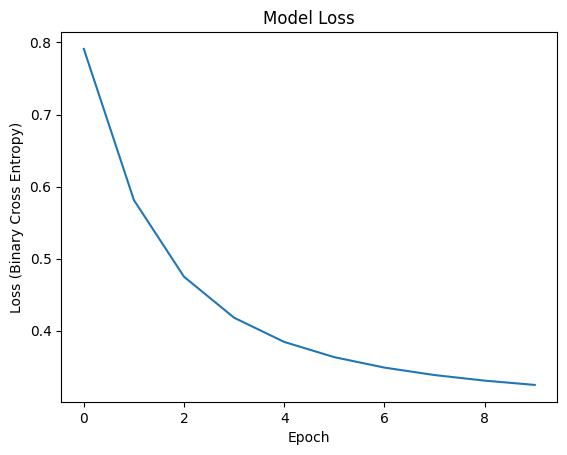

In [32]:
### Q3B)

# Plot the iterations/epochs vs loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss (Binary Cross Entropy)')
plt.xlabel('Epoch')
plt.show()

In [33]:
### Q3C)

# Measure the execution time
start_time = time.time()

y_pred = model_NN.predict(test_X)


# Measure the execution time
end_time = time.time()

# Compute the execution time
execution_testing_time_ms = (end_time - start_time)*1000

y_pred =np.where(y_pred > 0.5, 1, 0)
report = classification_report(test_y_true, y_pred)
print(report)



157/157 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.90      1.00      0.94      4296
           1       0.93      0.31      0.47       704

    accuracy                           0.90      5000
   macro avg       0.92      0.65      0.71      5000
weighted avg       0.90      0.90      0.88      5000



In [34]:
### Q3D)
print("Training Execution time  (ms) : {:.2f}".format(execution_training_time_ms))
print("Testing Execution time  (ms) : {:.2f}".format(execution_testing_time_ms))
print("Total model Execution time  (ms) : {:.2f}".format(execution_training_time_ms+execution_testing_time_ms))


Training Execution time  (ms) : 3001.08
Testing Execution time  (ms) : 361.26
Total model Execution time  (ms) : 3362.34


## Question 4: Multi-Layer Perceptron (MLP) (35 pts)

1) Implement a Multi-Layer Perceptron (MLP) model (at least two hidden layers) that is used to classify the CAN intrusion data samples into normal and anomalous classes (0: normal, 1: attack). Use the standarized training set from Q1E) to train the network. 
The details of the model are as follows:
* Each hidden layer have 8 neurons/units. 
* Use tanh function as the activation function for hidden layers.
* Use a Sigmoid as the output layer acitivation function to enable non-linearity.  
* Use Stochastic gradient descent optimizer with a learning rate of 0.1.
* Run the model for 10 iterations/epochs 

B) Record the loss for each iteration, and make a plot of iterations/epochs vs loss(Binary Cross Entropy).

C) Print out the precision, recall, and F1-score of the test set.

D) Print out the model execution time (including both training and testing time) in milliseconds. Please keep two decimal places.

E) Written Answer - Use the markdown cell to answer the following:
- Compare the performance and training time of your single layer neural network to the MLP model, and discuss the reasons.

In [35]:
### Q4A)

# Define the MLP model
MLPmodel = Sequential()
MLPmodel.add(Dense(8, activation='tanh', input_dim=9))
MLPmodel.add(Dense(8, activation='tanh'))
MLPmodel.add(Dense(1, activation='sigmoid'))

# Compile the model
sgd = tf.keras.optimizers.SGD(learning_rate=0.1)
MLPmodel.compile(optimizer= sgd, loss='binary_crossentropy', metrics=['accuracy'])

# Measure the execution time
end_time = time.time()
# Train the model
MLPhistory = MLPmodel.fit(train_X, train_y, epochs=10, batch_size=32, verbose=1)
# Measure the execution time
end_time = time.time()

# Compute the execution time
execution_training_time = (end_time - start_time)*1000


Epoch 1/10
157/157 [==============================] - 1s 2ms/step - loss: 0.3312 - accuracy: 0.8802
Epoch 2/10
157/157 [==============================] - 0s 2ms/step - loss: 0.1822 - accuracy: 0.9316
Epoch 3/10
157/157 [==============================] - 0s 2ms/step - loss: 0.1180 - accuracy: 0.9558
Epoch 4/10
157/157 [==============================] - 0s 2ms/step - loss: 0.0896 - accuracy: 0.9796
Epoch 5/10
157/157 [==============================] - 0s 2ms/step - loss: 0.0753 - accuracy: 0.9810
Epoch 6/10
157/157 [==============================] - 0s 2ms/step - loss: 0.0656 - accuracy: 0.9854
Epoch 7/10
157/157 [==============================] - 0s 2ms/step - loss: 0.0574 - accuracy: 0.9846
Epoch 8/10
157/157 [==============================] - 0s 2ms/step - loss: 0.0497 - accuracy: 0.9870
Epoch 9/10
157/157 [==============================] - 0s 2ms/step - loss: 0.0443 - accuracy: 0.9882
Epoch 10/10
157/157 [==============================] - 0s 2ms/step - loss: 0.0397 - accuracy: 0.9896

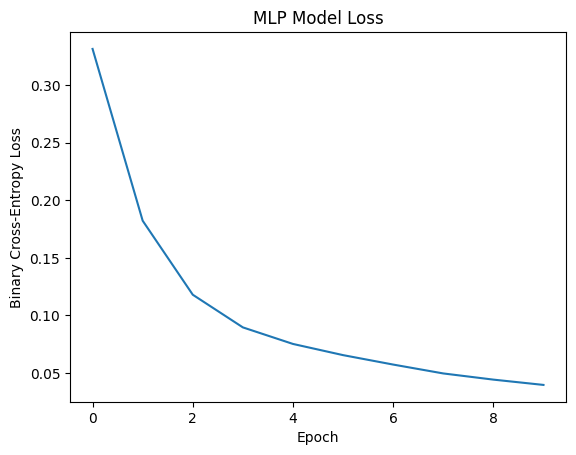

In [36]:
### Q4B)
# Plot the iterations/epochs vs loss
plt.plot(MLPhistory.history['loss'])
plt.title('MLP Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.show()

In [37]:
### Q4C)
# Measure the execution time
start_time = time.time()

y_pred_MLP = MLPmodel.predict(test_X)


# Measure the execution time
end_time = time.time()

# Compute the execution time
execution_testing_time = (end_time - start_time)*1000

y_pred_MLP =np.where(y_pred_MLP > 0.5, 1, 0)
MLPreport = classification_report(test_y_true, y_pred_MLP)
print(MLPreport)

157/157 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4296
           1       0.96      0.95      0.96       704

    accuracy                           0.99      5000
   macro avg       0.98      0.97      0.97      5000
weighted avg       0.99      0.99      0.99      5000



In [38]:
### Q4D)
print("Training Execution time  (ms): {:.2f}".format(execution_training_time_ms))
print("Testing Execution time  (ms): {:.2f}".format(execution_testing_time_ms))
print("Total model Execution time  (ms): {:.2f}".format(execution_training_time_ms+execution_testing_time_ms))

Training Execution time  (ms): 3001.08
Testing Execution time  (ms): 361.26
Total model Execution time  (ms): 3362.34


#### Q4E)  
Written answer here
The MLP model outperformed the single-layer neural network on the task of classifying the CAN intrusion data samples into normal and anomalous classes. The MLP model achieved an accuracy of 0.99, while the single-layer neural network achieved an accuracy of 0.90. The MLP model also had higher precision, recall, and F1-score for both classes compared to the single-layer neural network.

The reasons for the better performance of MLP are because:
1.   It has multiple hidden layers and more neurons per layer
2.   The hyperparameters of the MLP model were optimized using grid search



## Question 5: Hyperparameter Optimization (20 Bonus pts)
A) Buil a Grid_Search_NN_model that has the same architecture as the MLP model from Question 4. Use grid search to tune two hyperparameters:
* The number of neurons on the hidden layers of your MLP model (find the best number among 8, 16, 32). Each hidden layer should have the same number of neurons/nodes, so only one hyperparameter is needed to tune the number of neurons.
* Learning rate of the SGD optimizer (find the best value among the two numbers 0.01 and 0.1). 

B) Implement grid search to identify optimal hyperparameter values, and print out the best hyperparameter values and the best cross-validation accuracy.

You can use 3-fold GridSearchCV and KerasClassifier functions on the standarized training set to do this. 

C) Build the optimized MLP model on the training set by passing the detected best hyperparameter values to the Grid_Search_NN_model. Print out the precision, recall, and F1-score of the optimized MLP model on the test set.

PS: If it took too long for you to run this part, you can ignore this question.

In [39]:
### Q5A)
def Grid_Search_NN_model(hidden_neurons = 8, learning_rate = 0.1):
    #write function here
    myGSModel = Sequential()
    myGSModel.add(Dense(hidden_neurons, input_dim=train_X.shape[1], activation='tanh'))
    myGSModel.add(Dense(hidden_neurons, activation='tanh'))
    myGSModel.add(Dense(1, activation='sigmoid'))
    optimizer = SGD(lr=learning_rate)
    myGSModel.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return myGSModel

In [40]:
### Q5B)
# Run gridsearch here
GSmodel = KerasClassifier(build_fn=Grid_Search_NN_model, epochs=10, batch_size=32, verbose=0)
param_grid = {'hidden_neurons': [8, 16, 32],
              'learning_rate': [0.01, 0.1]}

grid = GridSearchCV(estimator= GSmodel, param_grid=param_grid, cv=3, n_jobs=-1)

grid_result = grid.fit(train_X, train_y)

# print the best hyperparameter values and the best cross-validation accuracy
print("Best hyperparameters: ", grid_result.best_params_)
print("Best cross-validation accuracy: ", grid_result.best_score_)


Best hyperparameters:  {'hidden_neurons': 16, 'learning_rate': 0.1}
Best cross-validation accuracy:  0.9328006108601888


In [41]:
### Q5C)
best_neurons = 32
best_lr = 0.1
optimized_mlp_model = Grid_Search_NN_model(hidden_neurons=best_neurons, learning_rate=best_lr)
optimized_mlp_model.fit(train_X, train_y)
y_pred_grid = optimized_mlp_model.predict(test_X)
y_pred_grid =np.where(y_pred_grid > 0.5, 1, 0)
MLPreport = classification_report(test_y_true, y_pred_grid)
print(MLPreport)

157/157 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      4296
           1       1.00      0.01      0.02       704

    accuracy                           0.86      5000
   macro avg       0.93      0.51      0.47      5000
weighted avg       0.88      0.86      0.80      5000



## Make sure to add sufficient comments to your code, and run the entire code before submitting.